In [1]:
# Uncomment to upgrade packages
# !pip3 install pandas --upgrade --quiet
# !pip3 install numpy --upgrade --quiet
# !pip3 install scipy  --upgrade --quiet
# !pip3 install statsmodels  --upgrade --quiet
# !pip3 install seaborn  --upgrade --quiet
# !pip3 install matplotlib  --upgrade --quiet
# !pip3 install scikit-learn  --upgrade 
# !pip install scikit-optimize  --quiet
!pip install apafib --upgrade  --quiet
!pip install ucimlrepo --upgrade  --quiet 

Objetivos de aprendizaje:
1. Hacer un mínimo análisis exploratorio de un conjunto de datos
2. Hacer el preproceso de un conjunto de datos para usar regresión
3. Saber plantear problemas de regresión sencillos y resolverlos usando diferentes
métodos
4. Interpretar los resultados de un problema de regresión

# Problema 6

En medicina, la prevención es clave, y la evaluación automática permite agilizar el proceso. El conjunto de datos **_Estimation of Obesity Levels_** recoge información de una población sobre sus hábitos y los clasifica según una escala discreta. El objetivo es robar diferentes modelos para predecir esta automatización.

Los datos se pueden cargar usando la librería `ucimlrepo` mediante la función `fetch_ucirepo(id=544)`.

In [ ]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn import set_config
from sklearn.metrics import  ConfusionMatrixDisplay, classification_report,accuracy_score, f1_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from yellowbrick.target.feature_correlation import feature_correlation

from ucimlrepo import fetch_ucirepo 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

import warnings

set_config(display='text')
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size':from sklearn.model_selection import GridSearchCV 16})
pd.set_option('display.precision', 3)

In [3]:
def save_results(clf, X_test, y_test, nclf, df):
    if hasattr(clf, 'best_score_'):
        df.loc[nclf,'train XV acc'] = clf.best_score_
    else:
        df.loc[nclf,'train XV acc'] = np.nan
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'precision score (M)'] = precision_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'recall score (M)'] = recall_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'f1 score (M)'] = f1_score(y_test, clf.predict(X_test), average='macro')
    return df

results_df = pd.DataFrame()

niter = 15
cv = 5

## Apartat a)
 - Dividir el conjunt de dades en (70%/30%).
 - Transformar les variables discretes en binaries (_one hot encoding_).
 - Normalitzar les dades, fer una visualització mínima i calcular les correlacions.
 - Aplicar PCA i t-SNE i interpretar els resultats en una representació de 2D. 

### Dividir el conjunt de dades
Abans de poder treballarles es primordial carregar el dataset.

In [4]:
data = fetch_ucirepo(id=544)
X = data.data.features
y = data.data.targets

In [5]:
X.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation


In [6]:
y.head().T

,0,1,2,3,4
NObeyesdad,Normal_Weight,Normal_Weight,Normal_Weight,Overweight_Level_I,Overweight_Level_II


Amb aixó, hem separat el dataset entre X i y, on la primera son les variables predictores (X) i la segona és la variable objectiu (y), que en aquest cas és la categoria d'obesitat ($NObeyesdad$). Podem veure que en el conjunt X n'hi ha variables númeriques i categoriques, també podem obesrvar que $NObeyesdad$ és categòrica. Aprofitarem ara per comprovar si existeix algun valor nul.

In [7]:
print(f' Total de valors nuls en X:',X.isna().sum().sum())  #Direcrtament ja ho sumem tot, si dona 0 és que no n'hi ha cap valor nul
print(f' Total de valors nuls en y:', y.isna().sum())

 Total de valors nuls en X: 0
 Total de valors nuls en y: NObeyesdad    0
dtype: int64


Perfecte, el que esparvem veure, no existeixen valors nuls, així que no ens hem de preocupar per ells. Ara aprofitarem ja per un futur de separar les variables categoriques de les numeriques.  

In [8]:
varCategoriques = X.select_dtypes(include=['object']).columns.tolist()
varNumeriques   = X.select_dtypes(include=[np.number]).columns.tolist()

print("Variables categòriques:", varCategoriques)
print("Variables numèriques:", varNumeriques)

Variables categòriques: ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
Variables numèriques: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']


Això pel que fa X, ara canviarem el format de y, ja que de moment es un element de llistes, i ho canviarem simplement que sigui categorica.

In [9]:
y_cat = y['NObeyesdad']
y_cat = y_cat.astype('category')
y_cat.cat.categories.tolist()

['Insufficient_Weight',
 'Normal_Weight',
 'Obesity_Type_I',
 'Obesity_Type_II',
 'Obesity_Type_III',
 'Overweight_Level_I',
 'Overweight_Level_II']

Ara si que podem dividir el dataset.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.3, random_state=92, stratify=y_cat)

print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)

print("\nProporció de y en original:")
print(y_cat.value_counts(normalize=True).sort_index())
print("\nProporció de y en conjunt de train:")
print(y_train.value_counts(normalize=True).sort_index())
print("\nProporció de y en conjunt de test:")
print(y_test.value_counts(normalize=True).sort_index())

Train shapes: (1477, 16) (1477,)
Test shapes: (634, 16) (634,)

Proporció de y en original:
NObeyesdad
Insufficient_Weight    0.129
Normal_Weight          0.136
Obesity_Type_I         0.166
Obesity_Type_II        0.141
Obesity_Type_III       0.153
Overweight_Level_I     0.137
Overweight_Level_II    0.137
Name: proportion, dtype: float64

Proporció de y en conjunt de train:
NObeyesdad
Insufficient_Weight    0.129
Normal_Weight          0.136
Obesity_Type_I         0.166
Obesity_Type_II        0.141
Obesity_Type_III       0.154
Overweight_Level_I     0.137
Overweight_Level_II    0.137
Name: proportion, dtype: float64

Proporció de y en conjunt de test:
NObeyesdad
Insufficient_Weight    0.129
Normal_Weight          0.136
Obesity_Type_I         0.167
Obesity_Type_II        0.140
Obesity_Type_III       0.153
Overweight_Level_I     0.137
Overweight_Level_II    0.137
Name: proportion, dtype: float64


Ara ja tenim dividit el dataset en un conjut de test i un altre de train, a més podem percebre que la proporció de y és igual pels dos conjuts, el que signficia que s'ha dividit bé.

### Transformar variables discretes en binaries

In [11]:
# Aplicar one-hot encoding
X_train_d = pd.get_dummies(X_train, drop_first=True)
X_test_d = pd.get_dummies(X_test, drop_first=True)

# Transformar varibale objectiu a codis numèrics
y_train_d = y_train.cat.codes
y_test_d = y_test.cat.codes

# Alinear test i train pq tinguin mateixes columnes
X_train_d, X_test_d = X_train_d.align(X_test_d, join='left', axis=1, fill_value=0)

print("Shape despres de dummies:", X_train_d.shape, "Test:", X_test_d.shape)
print("Codis de y_train:", np.unique(y_train_d))

print("\nColumnes numèriques:", varNumeriques)
print("Columnes categòriques (despres d'encoding):", [c for c in X_train_d.columns if c not in varNumeriques])

Shape despres de dummies: (1477, 22) Test: (634, 22)
Codis de y_train: [0 1 2 3 4 5 6]

Columnes numèriques: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
Columnes categòriques (despres d'encoding): ['Gender_Male', 'family_history_with_overweight_yes', 'FAVC_yes', 'CAEC_Frequently', 'CAEC_Sometimes', 'CAEC_no', 'SMOKE_yes', 'SCC_yes', 'CALC_Sometimes', 'CALC_no', 'MTRANS_Bike', 'MTRANS_Motorbike', 'MTRANS_Public_Transportation', 'MTRANS_Walking']


In [12]:
X_train_d.head().T

,232,945,399,665,75
Age,51.0,23.455,21.0,21.275,23.0
Height,1.59,1.703,1.65,1.737,1.63
Weight,50.0,75.0,60.0,50.479,45.0
FCVC,3.0,2.163,3.0,3.0,3.0
NCP,3.0,3.0,1.0,3.49,3.0
CH2O,3.0,2.153,1.0,1.327,3.0
FAF,2.0,1.078,0.0,0.792,2.0
TUE,0.0,1.503,0.0,0.128,0.0
Gender_Male,False,True,True,False,False
family_history_with_overweight_yes,True,True,False,True,True


### Normalitzar dades

Hem de normalitzar les variables numèriques perquè tinguin la mateixa escala i poder treballar amb elles. Les variables categòriques (que són binàries després del one-hot encoding) no s'han de normalitzar ja que al ser binàries ja estan en la mateixa escala [0, 1].

Primer veurem una mica les dades per decidir com normalitzr-les, si amb StandarScaler o MinMaxScaler.

In [13]:
X_train_d[varNumeriques].describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,1477.000,1477.000,1477.000,1477.000,1477.000,1477.000,1477.000,1477.000
mean,24.410,1.699,86.293,2.415,2.686,2.006,1.012,0.639
std,6.360,0.095,26.190,0.532,0.771,0.614,0.855,0.608
min,14.000,1.450,39.000,1.000,1.000,1.000,0.000,0.000
25%,20.000,1.626,65.000,2.000,2.659,1.551,0.115,0.000
50%,22.836,1.700,82.695,2.363,3.000,2.000,1.000,0.570
75%,26.000,1.767,107.560,3.000,3.000,2.482,1.683,1.000
max,56.000,1.980,173.000,3.000,4.000,3.000,3.000,2.000


Amb aquestes dades, és millor normalitzar amb **StandardScaler** que amb **MinMaxScaler**, ja que podem veure que en algunes variables es poden veure outliers:

- **Weight**: Màx de 173 kg quan el 75% (Q3) és només 107.56 kg.
- **Age**: Màx de 56 anys quan la mediana és 22.84 anys.
- **Height**: Gran rang de valors entre min i màx.

Si fessims servir **MinMaxScaler**, totes les variables anirien entre [0, 1], però els outliers es colocarien als extrems i tots els altres valors estarien comprimits en un rang estret (perdua informació). En canvi, amb **StandardScaler**, la forma de la distribució original es conserva i  els outliers no modifiquen tant el processat, ja que no alteren tant tot l'escalat.

In [14]:
scaler_final = StandardScaler()
X_train_d[varNumeriques] = scaler_final.fit_transform(X_train_d[varNumeriques])
X_test_d[varNumeriques] = scaler_final.transform(X_test_d[varNumeriques])

X_test_d[varNumeriques].describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,634.000,634.000,634.000,634.000,6.340e+02,634.000,634.000,634.000
mean,-0.051,0.100,0.037,0.023,-4.500e-04,0.010,-0.007,0.101
std,0.993,0.938,1.001,1.013,1.030e+00,0.995,0.985,1.005
min,-1.480,-2.554,-1.803,-2.662,-2.186e+00,-1.639,-1.185,-1.053
25%,-0.729,-0.600,-0.708,-0.781,-3.642e-02,-0.608,-1.027,-1.051
50%,-0.279,0.109,-0.087,0.055,4.076e-01,-0.010,-0.014,0.167
75%,0.250,0.777,0.784,1.099,4.076e-01,0.751,0.682,0.594
max,5.755,2.916,2.851,1.099,1.704e+00,1.619,2.327,2.240


Perfecte, ara ja tenim totes les dades processades, s'ha aplicat one hot encoding a les categòriques i s'han normalitzat les numèriques.

### Visualització mínima de les variables

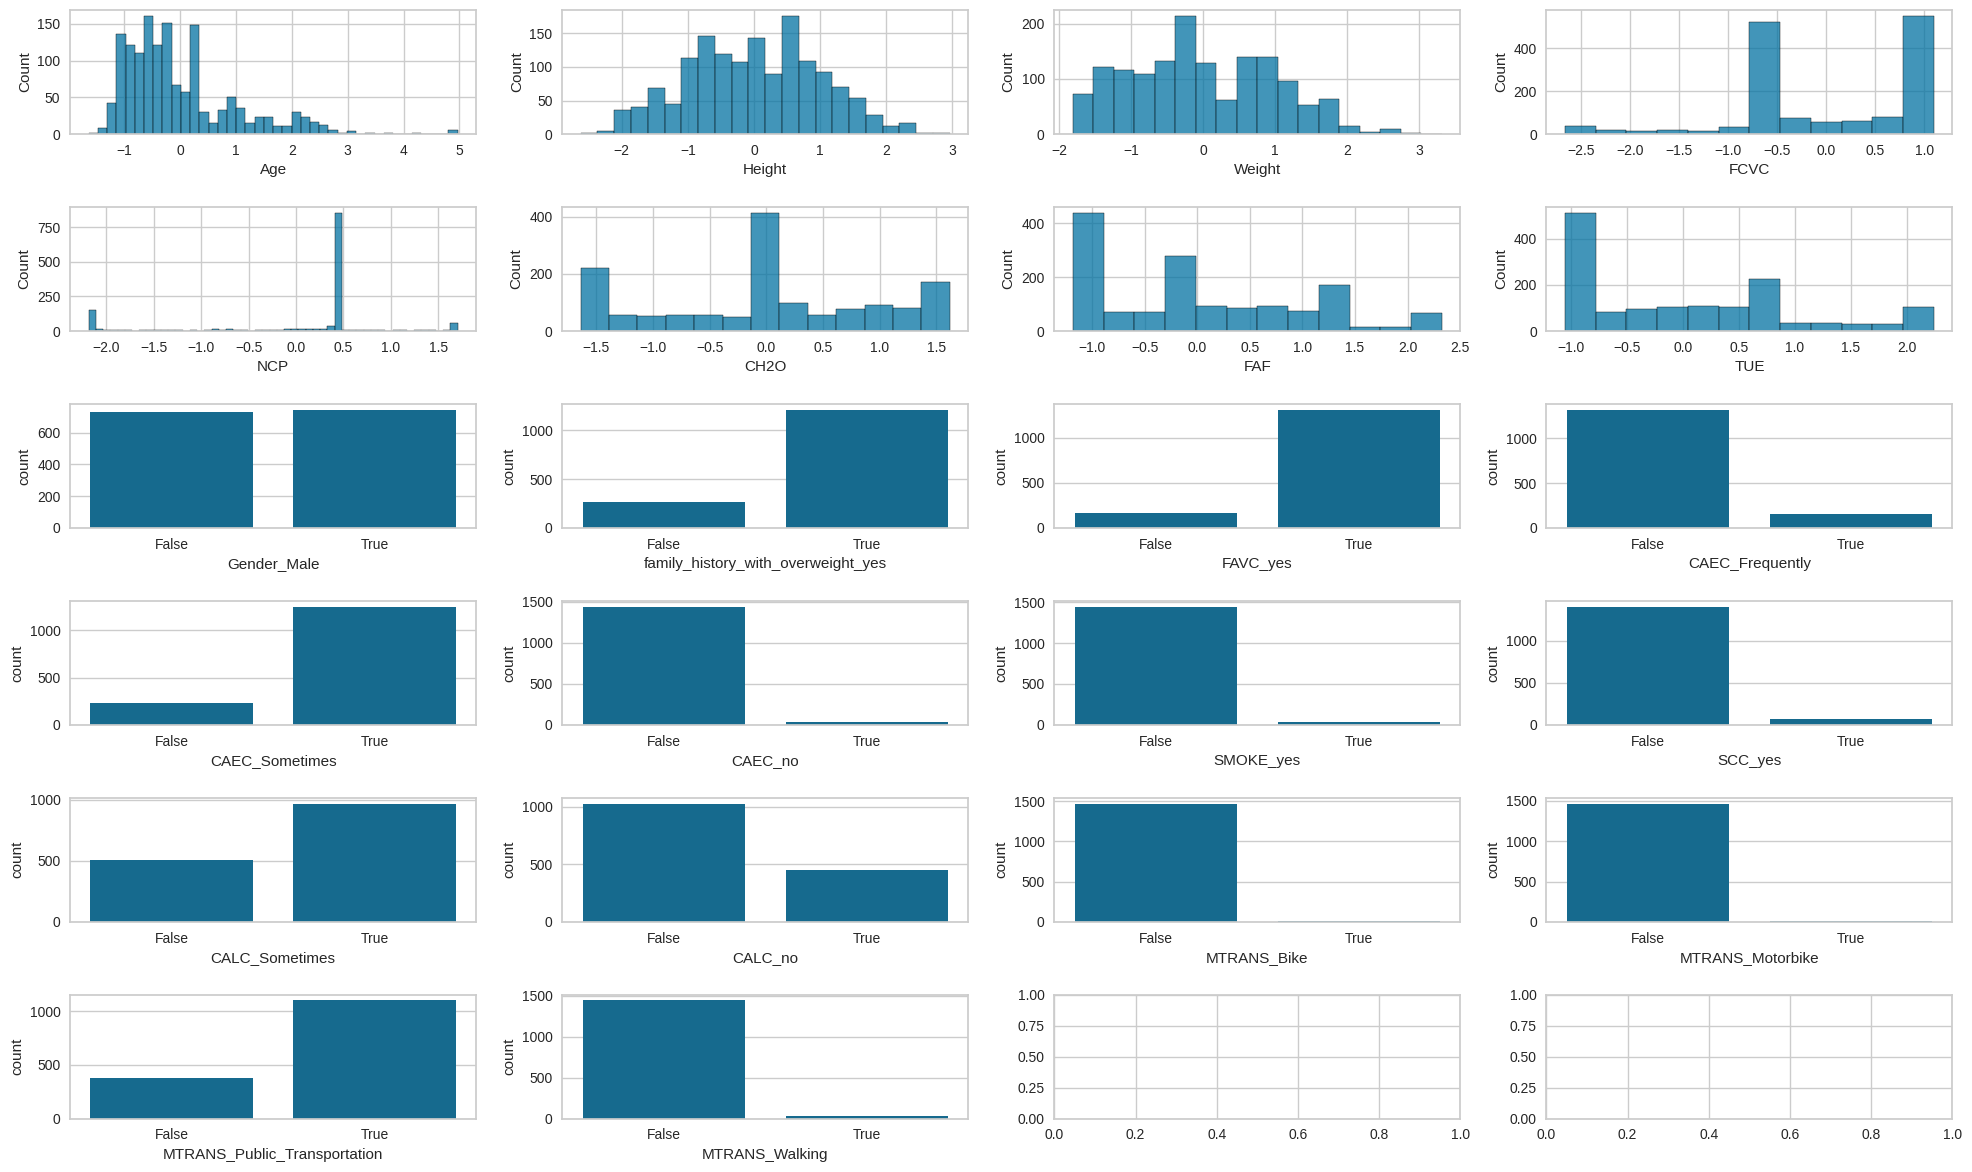

In [15]:
fig, axes = plt.subplots(6,4,figsize=(20,12))

X_train_frame = pd.DataFrame(X_train_d)
X_train_frame.columns=X_train_d.columns

for i, c in enumerate(X_train_d.columns):
    ax = axes.reshape(-1)[i]
    if X_train_d[c].nunique() < 3: #binaries
        a = sns.countplot(x = X_train_d[c], ax = ax)
    else:
        b =sns.histplot(x= X_train_d[c], ax = ax)
plt.tight_layout()


Amb els histogrames es pot veure que:
 - **Age** és pot veure que la distribució és una mica asimètrica.
 - **Height** i **Weight** és podria dir que segueixen una distribució gaussiana, ja que al voltant del 0 tenen certa simetria.
 - Respecte **FCVC** seria simètrica si no fos per la cua de la dreta.
 - **NCP** pràcticament tots els valors estan en el mateix punt.
 - **FAF i TUE**: Altament asimètriques a l'esquerra,

Pel que fa les binaries éstan totes desproporcionades excepte **Gender_Male** que és l'única que està balancejada.

### Correlacions

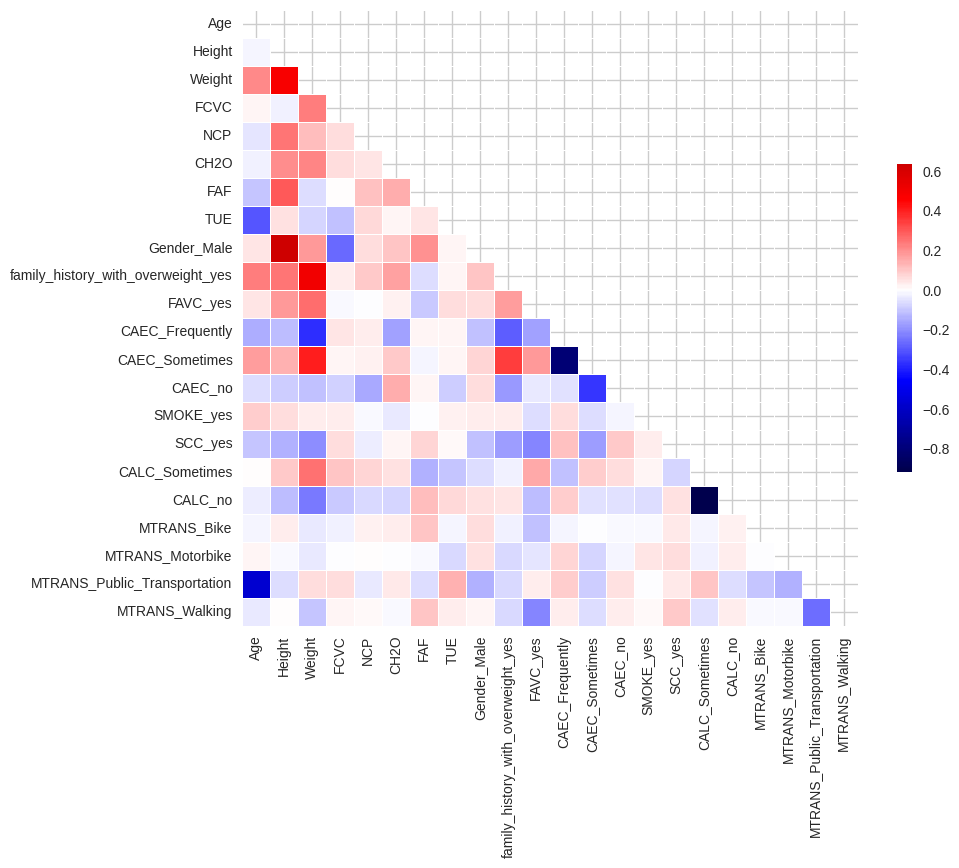

In [16]:
corr = X_train_d.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});


La correlació que més destaca seria la de **Weight** - **Height** amb forta correlació positiva, té cert sentit ja que normalment la gent més alta acostuma a pesar més. També és pot observa una forta correlacio entre **family_history_with_overweight_yes** - **Weight**, que es podria explicar que l'historial familiar està directament lligat amb el pes. També a destacar que **CAEC_Frequently** - **CAEC_Sometimes**  tenen forta correlació negativa, que te sentit que tingui ja que es la mateixa variable que s'ha dividit gràcies a One Hot Encoding.

<Figure size 1200x800 with 0 Axes>

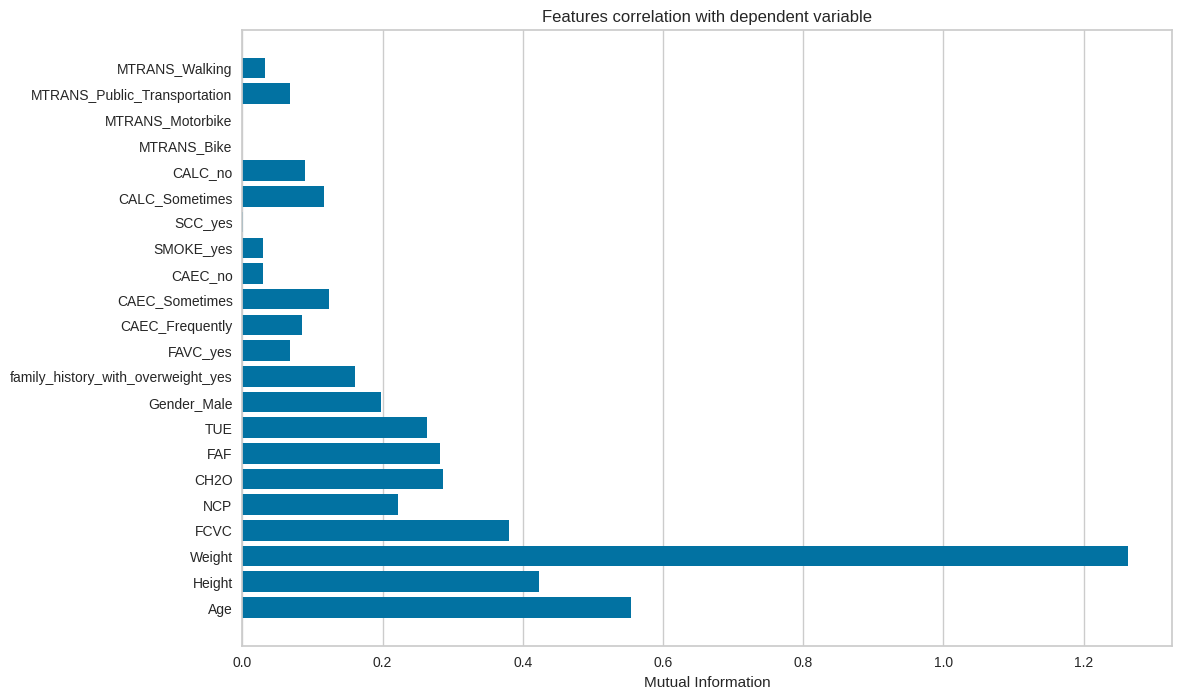

<Figure size 800x550 with 0 Axes>

In [17]:
plt.figure(figsize=(12,8))
visualizer = feature_correlation(X_train_d, y_train_d, labels=list(X_train_d.columns), method='mutual_info-classification', random_state=92);
plt.tight_layout()
plt.show()

Aquest gràfic ens mostra que per predir **NObeyesdad** la vairbales més significativa és **Weight**, que clarament és la que més destaca, després aniria seguida per **Age** i **Height**. I també ens mostra que les menys predictives són **MTRANS_motorbike**, **MTRANS_Bike** i **SCC_yes**.

### PCA i t-SNE

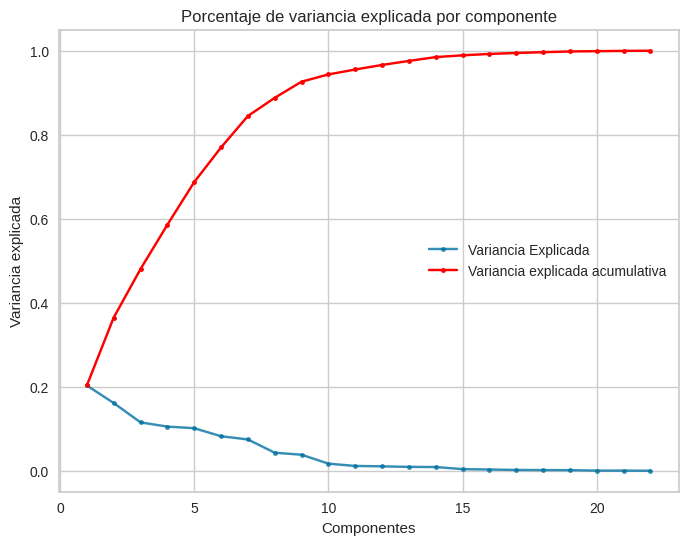

In [18]:
pca = PCA().fit(X_train_d)

fig = plt.figure(figsize=(8,6))
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),pca.explained_variance_ratio_ ,alpha=0.8,marker='.',label="Variancia Explicada")
y_label = plt.ylabel('Variancia explicada')
x_label = plt.xlabel('Componentes')
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red',marker='.',
         label="Variancia explicada acumulativa")
plt.legend()
plt.title('Porcentaje de variancia explicada por componente');


Podem veure que amb només els dos primers components ja podem explicar aproximadament el 25% d la variança total, i que a partir del setè component ja podem representar més del 80% de la variança.  
Estimant per la poca variança acumulada de les dues components, es bastant probable que al aplicar PCA no surti un resultat molt clar, així que ara, anem a aplciar PCA per veure el resutlat.

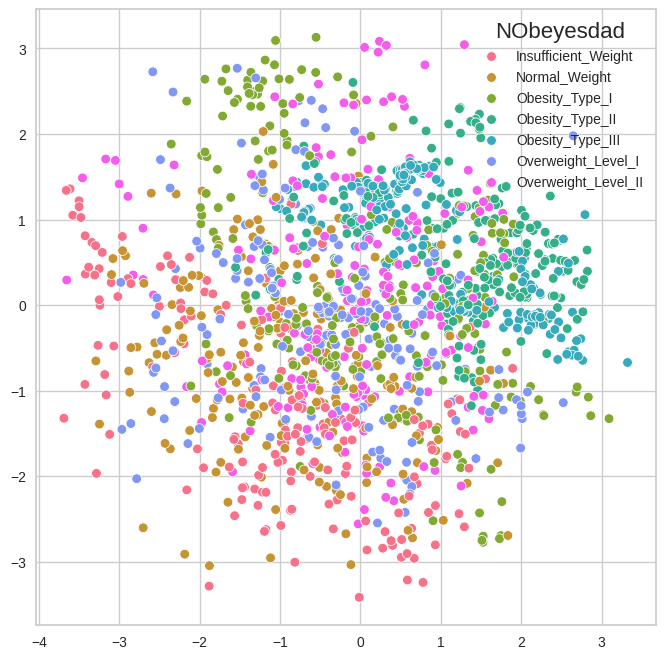

In [19]:
#PCA
X_trans = pca.transform(X_train_d)
fig = plt.figure(figsize=(8, 8))
sns.scatterplot(x=X_trans[:, 0], y=X_trans[:, 1], hue=y_train);

Pel que fa el **PCA** com hem suposat abans, que amb dos components no s'explicava bé el model ja que ña variança és molt pobre. Tots els grups estan solapats i no es detecta un patró clar, però si que es cert que el grup **Obesity_Type_III** si que sembla estar més junt que els altres. Però no existeix una separació clara. Amb això podem arribar a la conclusió que les relacions entre les variables no son lineals.

<Axes: >

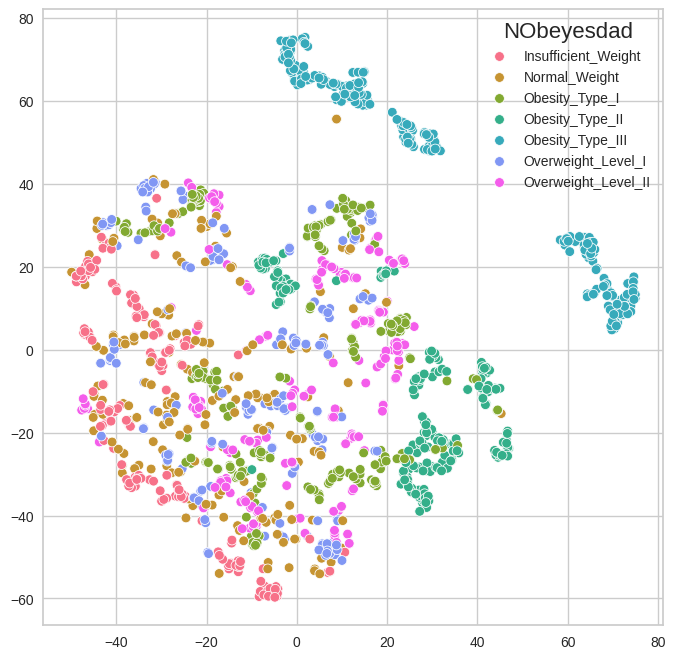

In [20]:
# t-SNE
X_trans = TSNE(n_components=2, perplexity=20, max_iter=2000, init='pca').fit_transform(X_train_d)
fig = plt.figure(figsize=(8, 8))
sns.scatterplot(x=X_trans[:, 0], y=X_trans[:, 1], hue=y_train)

Pel que fa el **t-SNE**, si que es veu una separabilitat més clara pels grups sobretot **Obesity_Type_III** i **Obesity_Type_II**, pel que fa el primer esta concentrat pel costat dret tirant cap a la cantonada, i pel que fa el segon si que es veu ben separat  i entre els seus grupets compacte. Com que **t-SNE** és no linel si que es veu una estructura més definida que en el **PCA**.

Conclusions:
 - El PCA no ens diu res clar ja que amb dos components no és pot representar.
 - t-SNE ens separa les classes
 - El dataset és no lineal

## Apartat b)
 - Aplciar Naïve Bayes
 - Discriminant lineal
 - Evaluar qualitat dels models


In [21]:
gnb = GaussianNB()
gnb.best_score_ = np.mean(cross_val_score(gnb, X_train_d, y_train_d, cv=10))
print(gnb.best_score_)

0.5030382423239568


La validació creuada té un resultat **molt pobre**, quasi seria el mateix tirar una moneda, és a dir, de cada dues persones, classifica malament una. Jutjant pel nostre dataset, no serà un bon model per prediure una clasificació d'obesitat.

In [22]:
gnb_model = GaussianNB().fit(X_train_d, y_train_d)
gnb_model.best_score_ = gnb.best_score_

print("Priors:", gnb_model.class_prior_)

Priors: [0.12863913 0.13608666 0.16587678 0.140826   0.15368991 0.13744076
 0.13744076]


Amb els priors podem veure que totes les classes tenen una probabilitat bastant similar, al voltant del 13-15% cadascuna. Podem veure que no hi ha cap classe que sigui especialment dominant sobre les altres. Així que jutjant per aquest valors, és bastant probable que aplicar Gaussian Naive Bayes no tingui bons resultats. Bé, però aixó no ho sabrem sense entrenar el model, així que ho farem.

In [23]:
y_pred_gnb_test = gnb_model.predict(X_test_d)
print(classification_report(y_test_d, y_pred_gnb_test, target_names=y_train.cat.categories))
results_df = save_results(gnb_model, X_test_d, y_test_d, 'GNB', results_df)

                     precision    recall  f1-score   support

Insufficient_Weight       0.46      0.80      0.59        82
      Normal_Weight       0.63      0.22      0.33        86
     Obesity_Type_I       0.44      0.43      0.44       106
    Obesity_Type_II       0.40      0.97      0.57        89
   Obesity_Type_III       0.99      1.00      0.99        97
 Overweight_Level_I       0.67      0.16      0.26        87
Overweight_Level_II       0.38      0.10      0.16        87

           accuracy                           0.53       634
          macro avg       0.57      0.53      0.48       634
       weighted avg       0.57      0.53      0.48       634



Resultats esperats gràcies a la validació creuada, el **f1-score** és de només 53% i la **precission** igual, d'un 57%. Pel que fa la precissió entre les classes, l'única amb bons resultats és **Obesity_Type_III** amb quasi 100% a totes les qualificacions, però pel que tots els altres grups, la precissio és molt pobre, rarament supera el 50%; i pel que da el **f1-scor** n'hi ha alguns grups amb molt mal valors, destacant **Overweight_Level_II**, aquest grup també cal destacar que te un **recall** horrible.

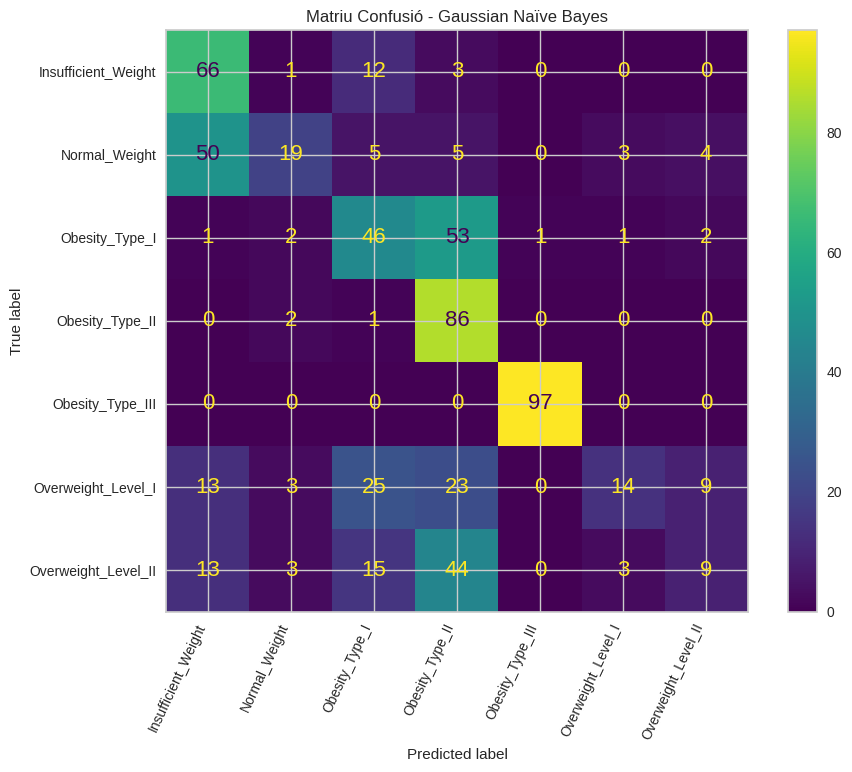

In [24]:
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_estimator(gnb_model, X_test_d, y_test_d,display_labels=y_train.cat.categories, ax=ax)
ax.set_title('Matriu Confusió - Gaussian Naïve Bayes')
plt.xticks(rotation=65, ha='right')
plt.tight_layout()
plt.show();

Que podem veure? Doncs que és un model relativament dolent, amb només una tasa de precissió del 50%, és a dir, com tira una moneda cara i creu. Destaca que l'únic que prediu al 100% és la categoria Obesity_Type_III. Totes les altres tenen mala precissió.

### LDA

El ``GNB`` assumeix que totes les variables són independents condicionalment, i per a cada classe gestiona cada variable com una distribució gaussiana. En canvi, un model de discriminant lineal (``LDA``) busca una combinació lineal entre les variables per maximitzar la separació entre les classes. Té en compte que totes les variables segueixen una distribució gaussiana multivariada, el que vol dir que considera les correlacions entre les variables en lloc de tractar-les com independents.  
Així que ara provarem d'aplicar el LDA per veure si té un enfoc diferent del GNB.

In [25]:
lda = LinearDiscriminantAnalysis()
lda.best_score_ = np.mean(cross_val_score(lda, X_train_d, y_train_d, cv = 10))
print(lda.best_score_)

0.8923561316418459


Ja de moment, comparant amb el PCA, el error de validació creuada és **molt millor**, apunta que el aquest model tindrà millors resultats. Aquest model si que es podria considerar per prediure el grau d'obesitat.

LDA priors: [0.12863913 0.13608666 0.16587678 0.140826   0.15368991 0.13744076
 0.13744076]


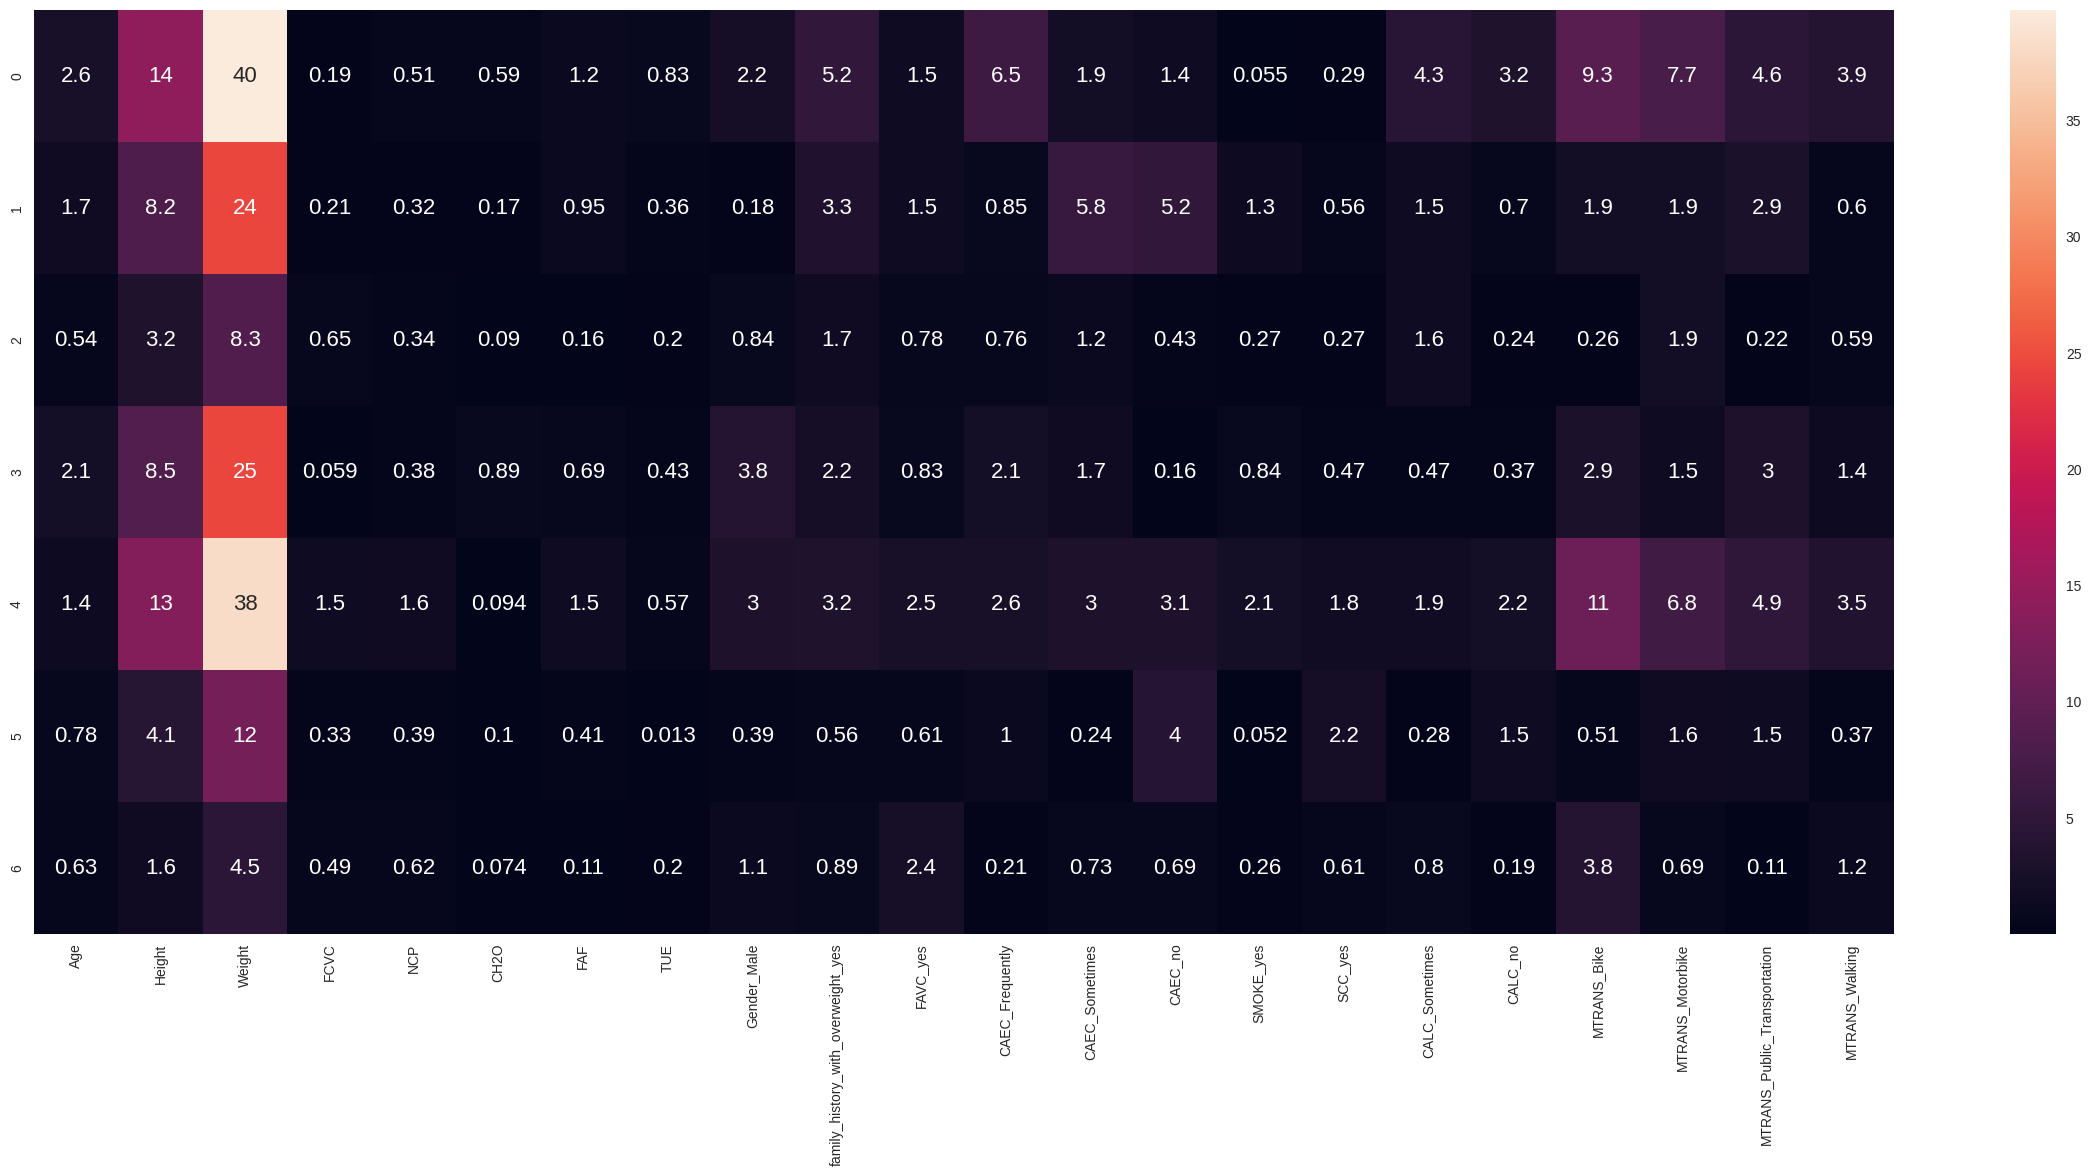

In [26]:
lda_model = LinearDiscriminantAnalysis().fit(X_train_d, y_train_d)

print("LDA priors:", lda_model.priors_)

coefs = pd.DataFrame(lda_model.coef_)
coefs.columns = X_train_d.columns

plt.figure(figsize=(30,12))
sns.heatmap(coefs.abs(), annot=True, cbar=True, xticklabels=True);


Podem veure que els atributs més importants son $Weight$ i $Height$, que són els que tenen més importància al llarg de totes les categories de la variable objectiu.

In [27]:
lda_model.best_score_ = lda.best_score_
y_pred_lda_train = lda_model.predict(X_train_d)
y_pred_lda_test = lda_model.predict(X_test_d)

print(classification_report(y_test_d, y_pred_lda_test, target_names=y_train.cat.categories))
results_df = save_results(lda_model, X_test_d, y_test_d, 'LDA', results_df)

                     precision    recall  f1-score   support

Insufficient_Weight       0.86      0.99      0.92        82
      Normal_Weight       0.91      0.72      0.81        86
     Obesity_Type_I       1.00      0.92      0.96       106
    Obesity_Type_II       0.94      1.00      0.97        89
   Obesity_Type_III       1.00      0.98      0.99        97
 Overweight_Level_I       0.76      0.82      0.79        87
Overweight_Level_II       0.79      0.83      0.81        87

           accuracy                           0.90       634
          macro avg       0.89      0.89      0.89       634
       weighted avg       0.90      0.90      0.90       634



Aqui els resultats ja són un altre cosa, aquí ja tenen care i ulls per un model classificador. Cal destacar el **f1-score** del 90% i el **precission** del 89%. A nivell individual totes les classes tenen molt bona precissió, quasi totes per sobre del 76%, remarcant que el que en tenen més són **Obesity_Type_I** i  **Obesity_Type_III** amb un 100%. El **recall** en general a nivell individual ha augmentat molt, és a dir, ha disminuit enormement els falsos negatius. I tirant per la mateixa tirada, el **f1-score** a nvell individual també té molts bons valors

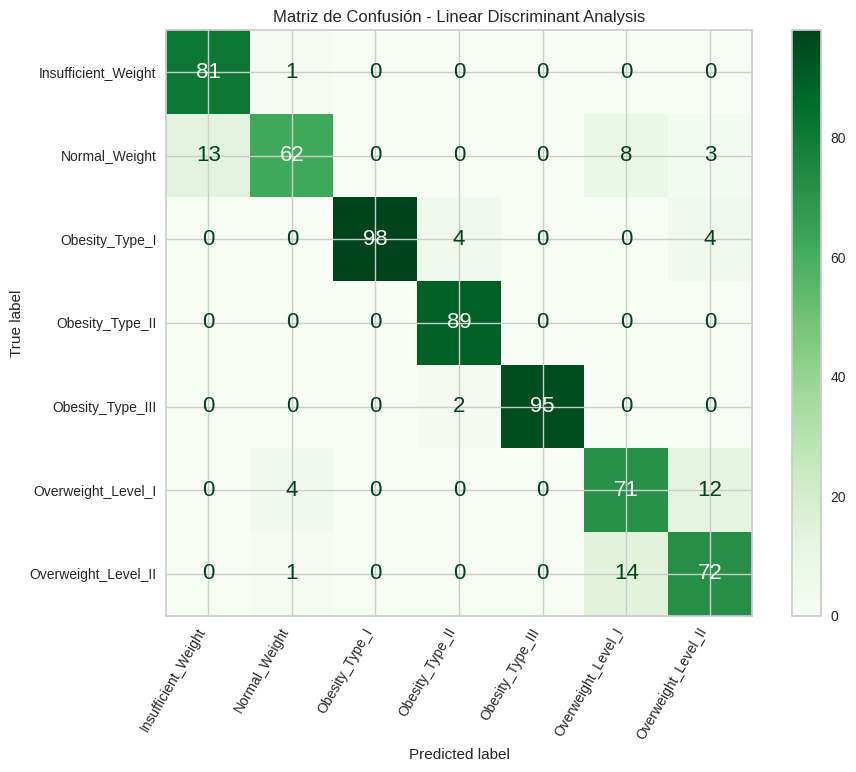

In [28]:
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_estimator(
    lda_model, X_test_d, y_test_d,
    display_labels=y_train.cat.categories,
    cmap='Greens', ax=ax
)
ax.set_title('Matriz de Confusión - Linear Discriminant Analysis')
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show();

Aques model té més probabilitat d'acert que el PCA, amb un 89%. La classe amb millor precissió és la mateixa que la del PCA, la Obesity_Type_III, però en aquest cas, cal destacacar que totes les altres categories han augmentat la precissió significativament.  
Jutgjant per la matriu de confusió, podem veure que son molt bons resultats, ja que exceptuant dues classes, totes les altres s'ajusten bé al valor real vs valor predit.

Al tenir tan bons resultats, seria interesant veure els components discrimintants del LDA, per veure la seva distribució


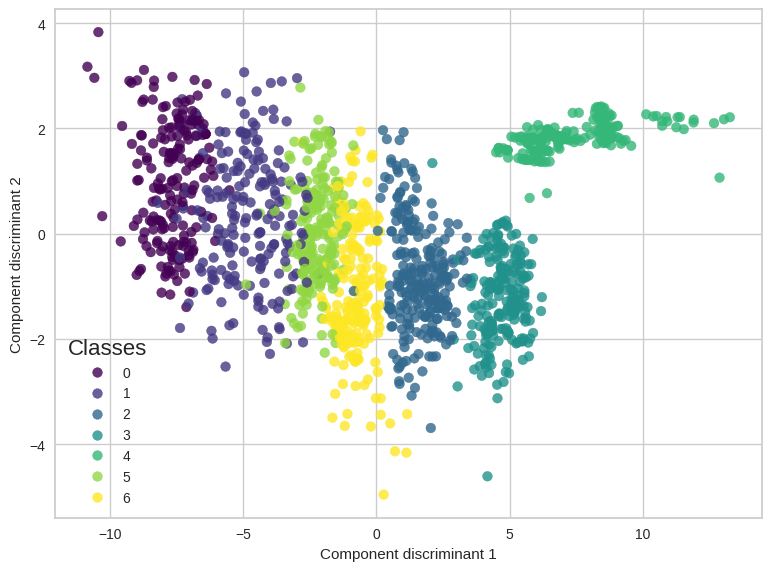

In [29]:
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(lda_model.transform(X_train_d)[:, 0],lda_model.transform(X_train_d)[:, 1],c=y_train_d, cmap='viridis',alpha=0.8)
ax.set_xlabel('Component discriminant 1')
ax.set_ylabel('Component discriminant 2')
ax.legend(*scatter.legend_elements(), title="Classes")
plt.tight_layout()
plt.show();


Ara sí que es poden veure els 7 grups ben diferenciats i separats. És a dir, el LDA **sí que separa les categories**. Mentres el PCA no mostrava rés clar, el LDA ensenya grups clars i ben definits.



### Evaluar qualitat dels models


In [30]:
results_df.sort_values(by=['test acc'], ascending=False)

,train XV acc,test acc,precision score (M),recall score (M),f1 score (M)
LDA,0.892,0.896,0.895,0.894,0.892
GNB,0.503,0.532,0.567,0.527,0.477


No puc agefir molt més que ja no hagi dit, el model **LDA** és clarament superior per a aquest problema que el model **GNB** (ja que és horrible). El supera en tots els aspectes, és quasi 2x millor.
En el **GNB** hi ha moltes prediccions incorrecte mentre que **LDA** és més confiable, el que significa que en el **LDA** n'hi haura menys falsos positius. Pel que fa el **recall** en el **GNB** (0.567) perd molts casos, en canvi en el **LDA** (89.4%) els té quasi tots en compte. I finalment, comparant el **f1-score** el **GNB** és horrible mentre que en el **LDA** esta ben equilibrat.  
També cal dir que hi ha una diferència mínima entre els valors d'entrenament i de test, el que vol dir que els models generalitzen bé.

Concluint, el **LDA** és significativament millor, millor mètriques. Per què és millor LDA? Doncs perquè com he dit abans té en compte les correlacions entre variables i que el GNB per definició assumeix independencia entre variables, quan em vist clarament que no és així.


## Apartat c)
 - Aplicar regressió logística explroant els hiperparàmetres.
 - Analitzar la importància de les variables mitjançant els pesos del model
 - Avaluar la qualitat dels models i comparar-los entre si.

In [31]:
lr = LogisticRegression(max_iter=10000)
param = {'penalty':['l1', 'l2'], 'C':10**np.linspace(-3,3,51, endpoint=True)}
lr_gs = GridSearchCV(lr, param, cv=10, n_jobs=-1, refit = True)
lr_gs.fit(X_train_d, y_train_d);

In [32]:
show_html(pd.DataFrame(lr_gs.cv_results_).loc[:,['params', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
101,"{'C': 1000.0, 'penalty': 'l2'}",0.957,1
99,"{'C': 758.5775750291835, 'penalty': 'l2'}",0.956,2
83,"{'C': 83.17637711026708, 'penalty': 'l2'}",0.956,3
97,"{'C': 575.4399373371566, 'penalty': 'l2'}",0.955,4
95,"{'C': 436.51583224016565, 'penalty': 'l2'}",0.955,5


Els millors hiperparàmetres han estat:
 - **Penalty**: l2
 - **C**: 251.18
 - **Accuracy**: 0.958

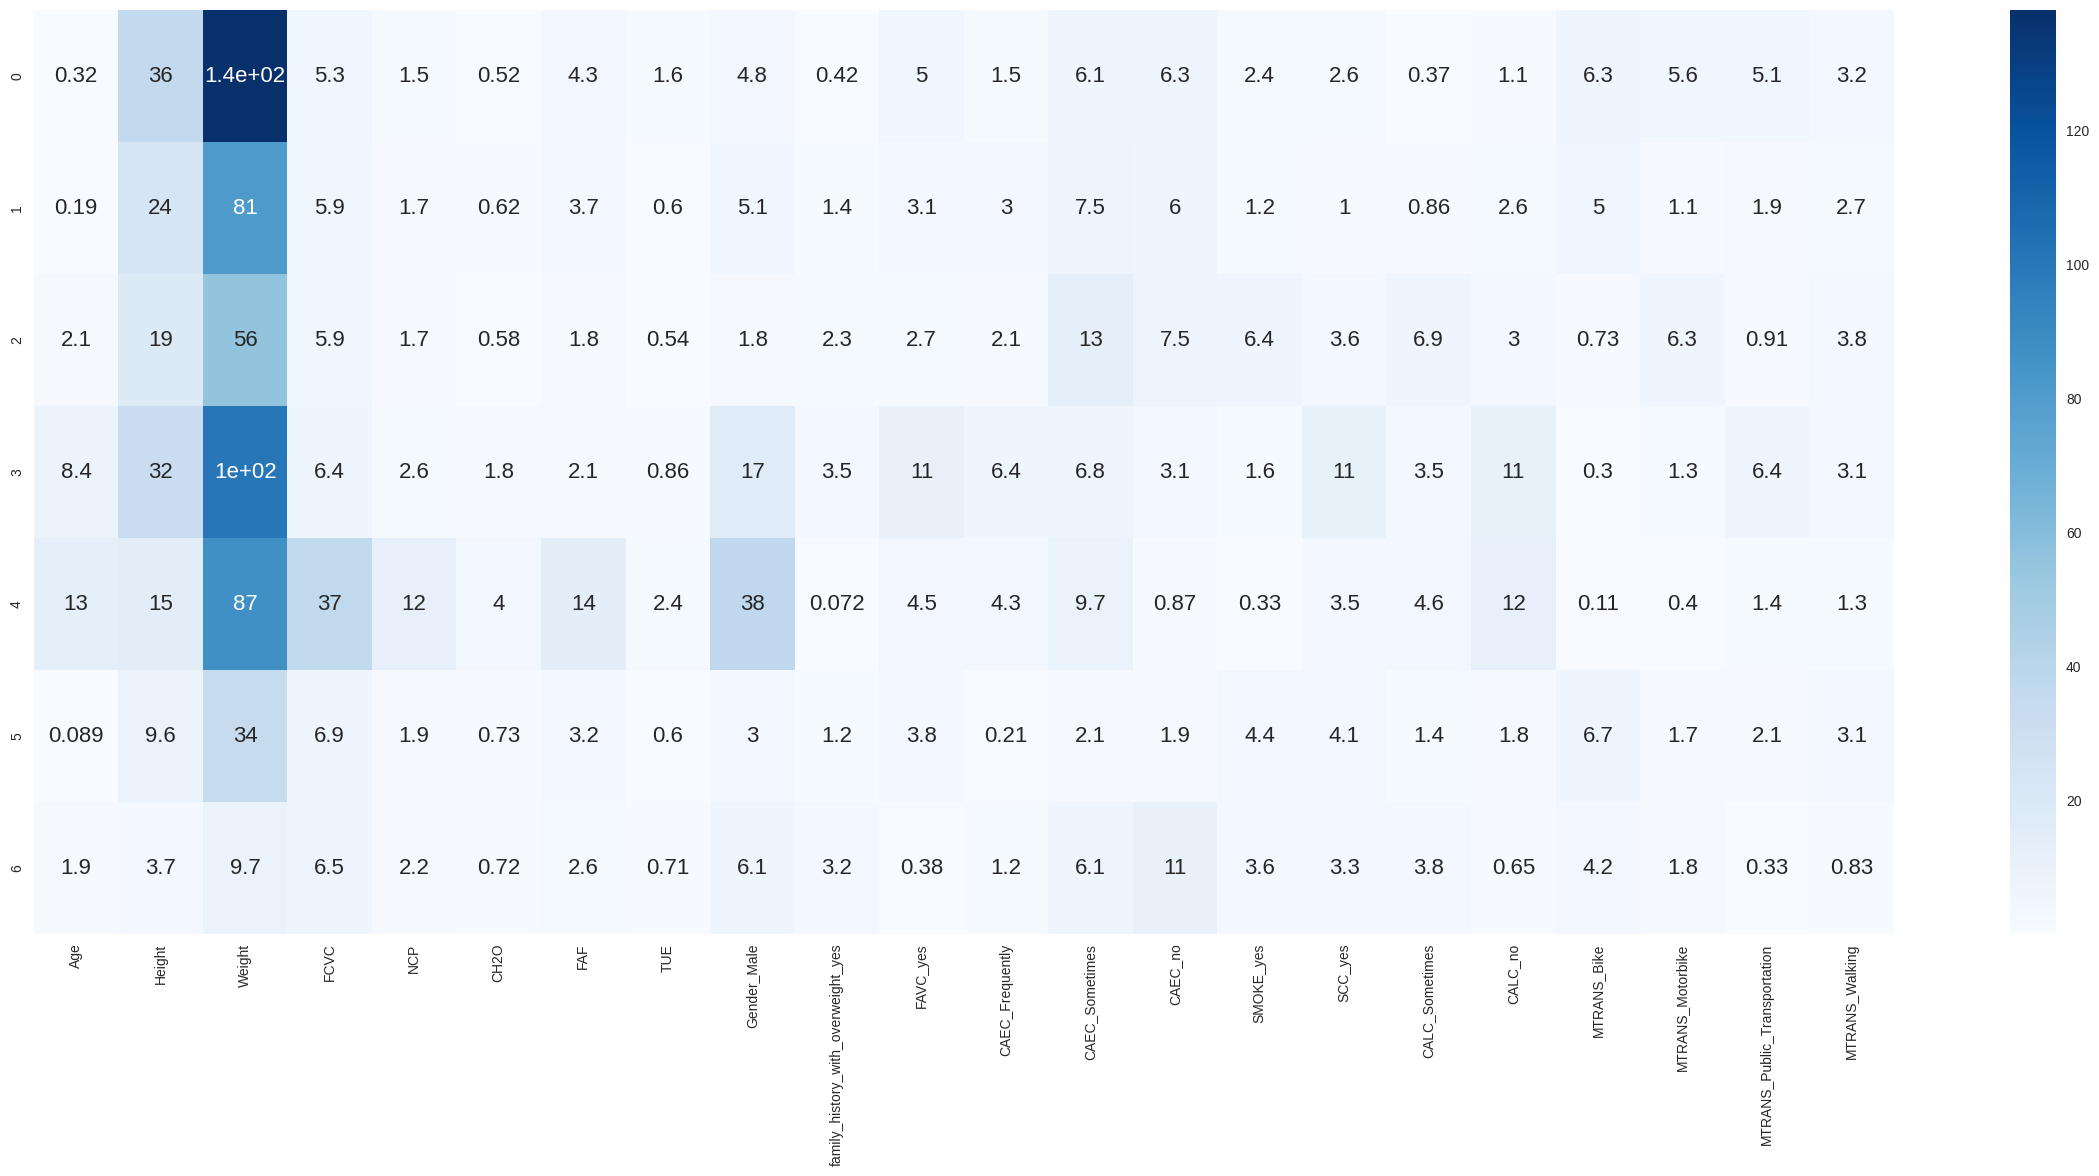

In [33]:
coefs = pd.DataFrame(lr_gs.best_estimator_.coef_)
coefs.columns = X_train_d.columns

plt.figure(figsize=(30,12))
sns.heatmap(coefs.abs(), annot=True, cbar=True, xticklabels=True, cmap='Blues');

És pot veure que no sempre les variables amb més pes d'una classe siguin també les de més pes de totes les classe. Variables més importants per classe:

 - **Insufficient_Weight** (grup 0): Variable més predictiva $Weight$ amb un coeficient de 93, $Height$ amb coef de 24 i en tercer lloc $CAECno$ amb 4.5. Totes les altres variables tenen pesos baixos.
 - **Normal_Weight** (grup 1): Variable més predictiva $Weight$ amb un coeficient de 54, seguit per $Height$ amb 16, i en tercer lloc amb coef de 5 tenim empatats $CAECsometimes$ i $CAECno$.
 - **Obesity_Type_I** (grup 2): Seguim igual, més predictiva  $Weight$ amb coef de 38, seguit per $Height$ amb 12 i $CAECno$ amb 6.6.
 - **Obesity_Type_II** (grup 3): $Weight$ amb coef de 64, $Height$ amb 20, $Gender_male$ amb 8.6 i $SCC_yes$ amb 7.7.
 - **Obesity_Type_III** (grup 4): $Weight$ amb coef de 56, empatats en segon lloc amb puntuació de 20 $Gender_male$ i $FCVC$, seguit $Height$ amb 11.
 - **Overweight_Level_I** (grup 5): Més predictiva $Weight$ amb coef de 21, seguit per $Height$ amb 5.9, i finalment en tercer lloc $FCVC$ amb 3.8.
 - **Overweight_Level_II** (grup 6): Més predictiva $Weight$ amb coef de 9.7, $CAECno$ amb 6.3 i $FCVC$ amb 3.4

En general, el que tenen en comú totes les classes és que la variable més predicitva és $Weight$ (classe 6 no tant dominant), seguidament per $Height$, també podem destacar que $Gender_male$ guanya pes en les classes 3 i 4. Després hi ha algunes variables que tenen vaig coeficient al llarg de totes les calsses, com ara $TUE$, $CH20$ i $NCP$. 

Comparant amb LDA els coeficients son bastants similars, en **LDA** els més dominants eren $Weight$ i $Height$, un comportament bastant semblant a la **Regressió Logistica**, si que és cert que en la regressió logística hi ha molts coefs que comparant amb el LDA han disminuit, sobretot les 4 ultimes columnes del gràfic.

In [34]:
print(classification_report(y_test_d, lr_gs.predict(X_test_d), target_names=y_train.cat.categories))
results_df = save_results(lr_gs, X_test_d, y_test_d, 'Logistic Regression', results_df)

                     precision    recall  f1-score   support

Insufficient_Weight       0.95      1.00      0.98        82
      Normal_Weight       0.98      0.95      0.96        86
     Obesity_Type_I       0.98      0.93      0.96       106
    Obesity_Type_II       0.97      0.98      0.97        89
   Obesity_Type_III       0.98      1.00      0.99        97
 Overweight_Level_I       0.91      0.92      0.91        87
Overweight_Level_II       0.91      0.90      0.90        87

           accuracy                           0.95       634
          macro avg       0.95      0.95      0.95       634
       weighted avg       0.95      0.95      0.95       634



No és pot dir gaire, els resultats parlen per ells sols, tenim molt bona **accuracy**, **recall** i **f1-score**, tots tres amb un valor del 95%. A nivell indivbidual, la classe més "pobre" seria la última, la de **Overweight_Level_II**, que és un comportanemt que és mantè per tots els models fins ara, però tot i que sigui la més pobre dins de les categories té els tres valors del 90%, és a dir, està molt bé, no es dolenta.

<Figure size 1000x800 with 0 Axes>

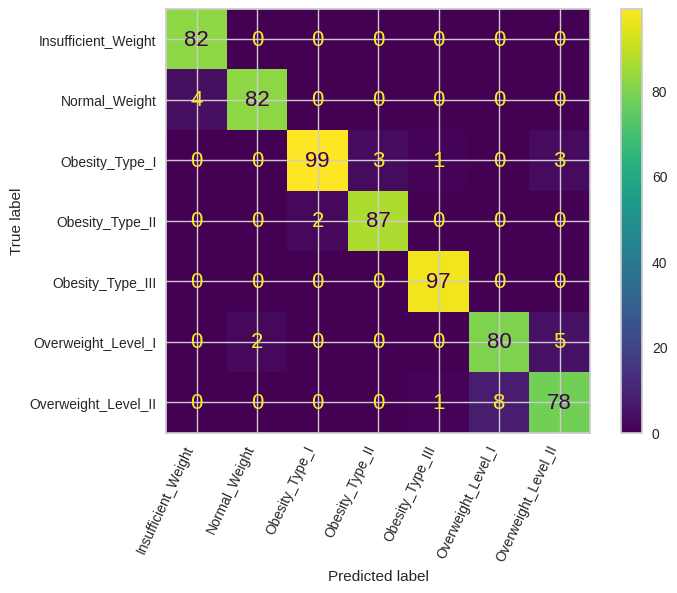

In [35]:
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_estimator(lr_gs, X_test_d, y_test_d,display_labels=y_train.cat.categories)
plt.xticks(rotation=65, ha='right')
plt.show();

No es pot comentar gaire més que no s'hagi comentat al classification report, s'observa que practicament no n'hi ha falsos negatius ni falsos positus, és a dir, aquest model s'adapta molt bé al nostre dataset.

In [36]:
results_df.sort_values(by=['test acc'], ascending=False)

,train XV acc,test acc,precision score (M),recall score (M),f1 score (M)
Logistic Regression,0.957,0.954,0.953,0.954,0.954
LDA,0.892,0.896,0.895,0.894,0.892
GNB,0.503,0.532,0.567,0.527,0.477


Dels 3 models fets fins ara, el millor és el de **Regressió Logística** amb un accuracy del 95% tant en el train com en el test, però és com que he dit és un model molt bo, **precissió**, *recall* i **f1-score** del 95%.  Aquest model supera al **LDA** en totes les métriques, i evidentment també ho fa amb el **GNB**.

Per què podria ser millor aquest model de **regressió logística** davant del **LDA**? Els dos són models lineals, però no es comporten igual. **LDA** assumeix la mateixa matriu de covariança per totes les classes i espera distribucions gaussianes. En canvi, la **regressió logística** és un model discriminatiu que modela P(Y|X) directament sense fer supòsits sobre X, a més, incorpora regularització ajustable (en aquest cas L2 amb paràmetre C), permetent controlar el sobreajustament, cosa que LDA no pot fer.

## Apartat d)
 - Ajusta un model de k-vecinos
 - Comparar resultats
 - Dictaminar quin s'adapta millor

### K-vecinos

In [37]:
knn = KNeighborsClassifier()
param = {'n_neighbors': list(range(1,37,2)), 'weights':['distance','uniform'], 'metric':['l2', 'l1','cosine', 'euclidean', 'manhattan']}
knn_gs = GridSearchCV(knn, param, cv=cv, n_jobs=-1)
knn_gs.fit(X_train_d, y_train_d);

In [38]:
show_html(pd.DataFrame(knn_gs.cv_results_).loc[:,['params', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
38,"{'metric': 'l1', 'n_neighbors': 3, 'weights': 'distance'}",0.886,1
146,"{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}",0.886,1
37,"{'metric': 'l1', 'n_neighbors': 1, 'weights': 'uniform'}",0.883,3
36,"{'metric': 'l1', 'n_neighbors': 1, 'weights': 'distance'}",0.883,3
144,"{'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'distance'}",0.883,3


De tots els valors que s'han provat els millors hiperparametres són:
 - **Metric**: l1 / manhattan       (en aquest cas agafara l1, però les dues tenen la mateixa score)
 - **n_neighbors**: 3
 - **weights**: distance
 - **Accuracy**: 0.886

In [39]:
print(classification_report(y_test_d, knn_gs.predict(X_test_d), target_names=y_train.cat.categories))
results_df = save_results(knn_gs, X_test_d, y_test_d, 'KNN', results_df)

                     precision    recall  f1-score   support

Insufficient_Weight       0.86      0.95      0.90        82
      Normal_Weight       0.83      0.69      0.75        86
     Obesity_Type_I       0.93      0.95      0.94       106
    Obesity_Type_II       0.99      0.99      0.99        89
   Obesity_Type_III       0.97      1.00      0.98        97
 Overweight_Level_I       0.84      0.87      0.85        87
Overweight_Level_II       0.88      0.84      0.86        87

           accuracy                           0.90       634
          macro avg       0.90      0.90      0.90       634
       weighted avg       0.90      0.90      0.90       634



El model és molt bo, té les tres mètriques, **precission**, **recall** i **f1-score**  del 90%. A nivell individual tenim que clasifica millor es Obesity_Type_III (comú en tots els models), i per la nostra sorpresa ara el pitjor ja no es Overweight_Level_II, sino que el que prediu pitjor és el Normal_Weight, pel que fa les altres, tenen les mètriques al voltant del 85-90%.

<Figure size 1000x800 with 0 Axes>

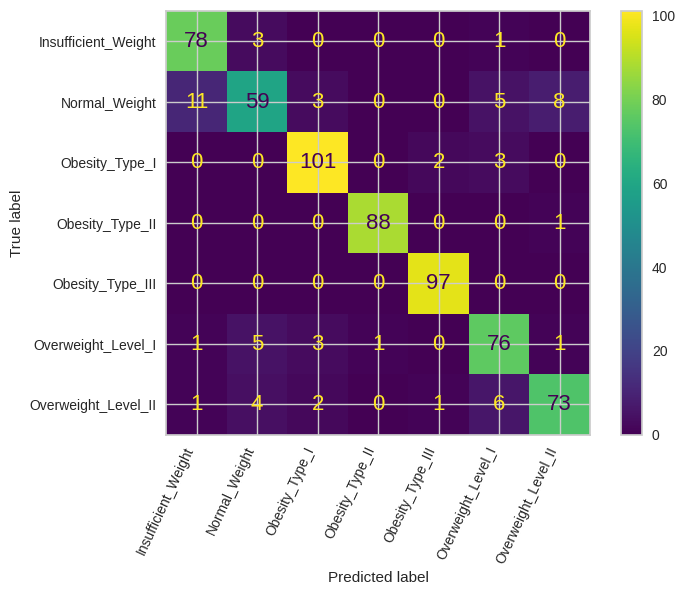

In [40]:
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_estimator(knn_gs, X_test_d, y_test_d,display_labels=y_train.cat.categories)
plt.xticks(rotation=65, ha='right')
plt.show();

Torno a repetir-me, no es pot dir molt més, els resultats ja parlen per ells sols. És pot veure que la que prediu pitjor es Normal_Weight, que els confon amb Insufficient_Weight, però a banda d'aquesta classe totes les altres les prediu bé.

### Comparar i avaluar resultats

In [41]:
results_df.sort_values(by=['test acc'], ascending=False)

,train XV acc,test acc,precision score (M),recall score (M),f1 score (M)
Logistic Regression,0.957,0.954,0.953,0.954,0.954
KNN,0.886,0.902,0.898,0.899,0.897
LDA,0.892,0.896,0.895,0.894,0.892
GNB,0.503,0.532,0.567,0.527,0.477


Hem treballat aquest dataset amb 4 models per predeir la variable NObeyesdad que han estat **GNB**, **LDA**, **Regressió Logística** i **KNN** (K-vecinos). 
De tots aquests models, el que ens ha donat millors resultats ha esta **Logistic Regression** amb un 95.3% d'accuracy i també un **f1-score** de 95.3%; seguit per **KNN** amb una accuracy de 90.2% i un **f1-score** de 89.7%; i els que van darrere ja ens els sabem, **LDA** i **GNB**.

Per què la **Regressió Logística** supera a **KNN**? La diferència principal es que el **KNN** treballa a nivell local (K = 3) mentre que la **Regressió Logística** treball amb tot el dataset, llavors té més informació. És a dir, el **KNN** ignora els patrons del dataset i és més sensible al soroll (ja que treballa a nivell local), en cavi **Regressió Logística** si que te en conta aquests patron i és menys sensible al soroll, el que fa que en general generalitzi millor.

Llavors... Quin model seria el millor per assignar un valor de la escala (NObeyesdad) a noves persones?   
Doncs basant-me amb tots els socre, el model que millor faria la feina seria el de **Regressió Logística** és el model que té millor **f1-score** i també el que ha obtingut més precissió al test, s'ha de dir també que l'overfitting entre el test i el train es mínim.
 
